# Numerics for the SYK quantum batteries

let us start by including the relevant packages

In [1]:
include("/home/dario/Documents/ChargingPower/src/ChargingPower.jl")
using .ChargingPower

In [2]:
using SparseArrays
using KrylovKit
using ExponentialUtilities
using Graphs
using Plots

In [3]:
n_majorana = 20
min_t = 10^-1 
max_t = 10^3
number_of_points = 10^4
points = exp.(log(min_t):((log(max_t) - log(min_t)) / (number_of_points - 1)):log(max_t))


10000-element Vector{Float64}:
   0.10000000000000002
   0.10009215505167934
   0.10018439502889412
   0.10027672000990762
   0.10036913007305502
   0.10046162529674393
   0.10055420575945404
   0.10064687153973735
   0.1007396227162184
   0.1008324593675941
   ⋮
 992.6580753801127
 993.5728599424777
 994.488487525029
 995.4049589046521
 996.3222748589505
 997.240436166239
 998.1594436055545
 999.0792979566509
 999.9999999999998

In [4]:
majorana_matrices = majorana_operators(n_majorana)
graph = complete_graph(n_majorana)

{20, 190} undirected simple Int64 graph

In [9]:
battery_hamiltonian = Z_model_hamiltonian(majorana_matrices)
charging_hamiltonian = SYK_hamiltonian(majorana_matrices, graph)

1024×1024 SparseMatrixCSC{ComplexF64, Int64} with 47104 stored entries:
⎡⣿⣿⣿⣿⣷⣿⣿⣾⢦⡀⣿⣿⡾⢦⡀⠳⣄⠀⠀⠀⣿⣷⡝⢦⡈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⣿⣿⣿⣿⣿⡯⡛⢻⣶⣿⣮⡛⢻⣶⣿⡂⠈⠳⣄⠀⢮⡛⣷⣶⣝⠀⠈⠳⣄⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⎥
⎢⣽⣿⡿⡿⠿⣧⣬⣮⣿⣿⣇⠙⠮⠻⠿⣦⣤⣠⡈⠳⣄⠙⠎⠻⢿⣤⣄⢤⡈⠳⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⎥
⎢⣻⣿⣿⣈⡢⣿⣿⣿⣿⣿⡏⠳⣄⠀⠀⡻⣿⣯⣙⣦⠈⠳⣄⠀⢈⡻⣿⣇⣙⢦⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⎥
⎢⠈⠳⣼⣿⣿⣿⣿⣿⣿⣿⡇⠀⠈⠳⣄⠙⢦⡸⣿⣿⠀⠀⠈⠳⣄⠙⢦⡻⣿⣷⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⎥
⎢⣿⣿⣮⠻⣍⠙⢯⡉⠉⠉⣿⣿⣿⣿⣿⣿⣿⣿⢮⡉⠳⣄⠀⠀⠈⠀⠀⠁⠈⠹⣿⣷⡝⢦⡈⠳⣄⠀⠀⠈⎥
⎢⠺⣏⢻⣶⣮⡃⠀⠙⢦⡀⣿⣿⣿⣿⣿⡯⡛⢻⣶⣿⠀⠈⠳⣄⠀⠀⠀⠀⠀⠐⢮⡛⣷⣶⣝⠀⠈⠳⣄⠀⎥
⎢⢤⡈⠻⠻⠻⣧⣤⡠⣄⠙⣿⣿⡿⡿⠿⣧⣬⣮⣿⣿⠀⠀⠀⠈⠳⣄⠀⠀⠀⠠⣄⠙⠎⠻⢿⣤⣄⢤⡈⠳⎥
⎢⠀⠙⢦⡀⠀⣻⡿⣿⣈⡳⣿⣿⣿⣈⡢⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠈⠳⣄⠀⢈⡻⣿⣇⣙⢦⎥
⎢⠀⠀⠀⠙⢦⡈⠳⣼⣿⣿⡎⠳⣼⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠈⠳⣄⠙⢦⡻⣿⣷⎥
⎢⢿⣿⣮⠳⣄⠙⢦⡀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⡟⢦⡸⣿⣿⡟⢦⡈⠳⣄⠀⠀⠀⎥
⎢⠳⣍⢹⣿⣮⡁⠀⠙⢦⡀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⠪⡉⣿⣿⣿⢮⡉⣿⣾⣯⠀⠈⠳⣄⠀⎥
⎢⢦⡈⠓⠙⠛⣷⣦⡰⣄⠙⠂⠀⠀⠀⠙⢦⡀⠀⠀⠀⣿⣿⡻⡛⢻⣶⣾⣾⣿⣿⣄⠙⠊⠛⢻⣦⣦⣦⡈⠓⎥
⎢⠀⠙⢦⡀⠀⣝⠿⢿⣬⡳⠄⠀⠀⠀⠀⠀⠙⢦⡀⠀⣿⠿⣧⣬⣺⣿⣿⣿⣿⣿⠈⠳⣄⠀⢨⡻⠿⣧⣹⡦⎥
⎢⡀⠀⠀⠙⢦⡈⠳⣜⢿⣿⣆⡀⢀⠀⠀⡀⠀⠀⠙⢦⣈⡳⣿⣿⣿⣿⣿⣿⣿⣿⣀⣀⣈⣳⣄⣙⣦⡻⣿⣿⎥
⎢⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⢿⣿⣮⠳⣄⠙⢦⡀⠀⠀⣿⣿⡎⠳⣄⠙⢦⡀⠀⢸⣿⣿⣿⣿⣿⣿⣿⡟⢦⡀⎥
⎢⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠳⣍⢹⣿⣮⡁⠀⠙⢦⡀⠻⣍⣻⣿⣮⠀⠀⠙⢦⣸⣿⣿⣿⣿⣿⠪⡉⣿⣿⣯⎥
⎢⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⢦⡈⠓⠙⠛⣷⣦⡰⣄⠙⢦⡈⠋⠛⠻⣶⣦⡲⣄⢹⣿⣿⡻⡛⢻⣶⣾⣾⣿⣟⎥
⎢⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡀⠀⣝⠿⢿⣬⡳⠀⠙⢦⡀⠨⣿⠿⣧⣬⡻⣿⠿⣧⣬⣺⣿⣿⣿⣿⣿⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢦⡈⠳⣜⢿⣿⠀⠀⠀⠙⢦⠈⠳⡾⣿⣿⠈⠳⡿⣿⣿⢿⣿⣿⣿⣿⎦

In [10]:
ground_state_rough = eigsolve(battery_hamiltonian, rand(ComplexF64, floor(Int, 2^(n_majorana/2))), 1, :SR)
e_0 = real(ground_state_rough[1][1])
ground_state = ground_state_rough[2][1]
energy_list = [0.0]

1-element Vector{Float64}:
 0.0

In [11]:
for index in eachindex(points) 
    if index != length(points)
        ground_state = expv(- im * (points[index + 1] - points[index]), charging_hamiltonian, ground_state)
        push!(energy_list, 2 * (real(ground_state' * battery_hamiltonian * ground_state) - e_0) / (points[index + 1] + points[index]))
    end
end


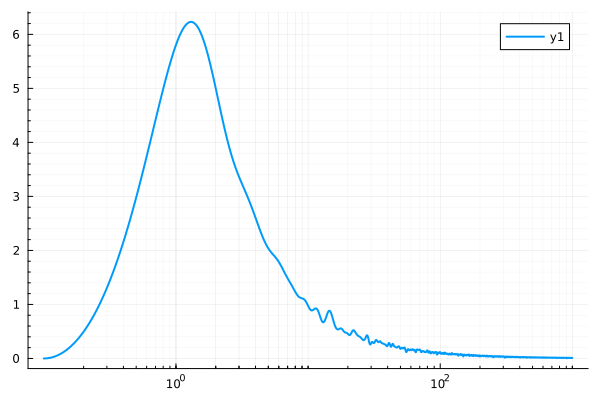

In [12]:
plot(points[2: length(points)], energy_list[2: length(points)], xaxis=:log, linewidth=2, minorgrid=true)
     